In [27]:
import re
import nltk
import spacy
from xml.dom import minidom
from nltk.wsd import lesk
from collections import Counter
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from pyvis.network import Network

In [28]:
def pre_processing(sentence):
    return remove_stopwords(tokenize_sentence(remove_punctuation(sentence)))

# Remove punctuation from a list of words
def remove_punctuation(sentence):
    return re.sub(r'[^\w\s]', '', sentence)

# Remove stopwords from a list of words
def remove_stopwords(words_list):
    stopwords = open("stop_words_FULL.txt", "r")
    stopwords_list = []
    for word in stopwords:
        stopwords_list.append(word.replace('\n', ''))
    stopwords.close()
    return [value.lower() for value in words_list if value.lower() not in stopwords_list]

# Tokenize the input sentence and also lemmatize its words
def tokenize_sentence(sentence):
    words_list = []
    lmtzr = WordNetLemmatizer()
    for tag in nltk.pos_tag(word_tokenize(str(sentence))):
        if tag[1][:2] == "NN":
            words_list.append(lmtzr.lemmatize(tag[0], pos=wn.NOUN))
        elif tag[1][:2] == "VB":
            words_list.append(lmtzr.lemmatize(tag[0], pos=wn.VERB))
        elif tag[1][:2] == "RB":
            words_list.append(lmtzr.lemmatize(tag[0], pos=wn.ADV))
        elif tag[1][:2] == "JJ":
            words_list.append(lmtzr.lemmatize(tag[0], pos=wn.ADJ))
    return words_list

# Union of the pre-processed words of the definitions and terms from the examples in WN for a sense.
def get_signature(sense):
    signature = []
    for word in tokenize_sentence(sense.definition()):  # definition tokenization
        signature.append(word)
    for example in sense.examples():  # example tokenization
        for word in tokenize_sentence(example):
            # Merge definition and examples
            signature.append(word)
    return signature

Given an subject, obtain the object.

In [29]:
def search_obj(sentence, verb, pattern):
    for token in sentence:
        if token.head.text == verb and token.dep_ == 'dobj' and len(
                pattern) < 2 and token.text != '\n  ' and token.text != '\n':
            dep2 = token.text, token.tag_, token.head.text, token.dep_
            return dep2

Given an object, obtain the subject.

In [30]:
def search_subj(sentence, verb, pattern):
    for token in sentence:
        if token.head.text == verb and token.dep_ == 'nsubj' and len(
                pattern) < 2 and token.text != '\n  ' and token.text != '\n':
            dep1 = token.text, token.tag_, token.head.text, token.dep_
            return dep1

Given a pattern like [dep1, dep2, sentence], do WSD using Lesk algorithm. 
It returns a new pattern with word_super_sense1, word_super_sense2.

Pattern example: [('You', 'PRP', 'buy', 'nsubj'), ('products', 'NNS', 'buy', 'dobj'), 
You can buy our products by PAYPAL Or Credit Card. 
  ]

In [31]:
def disambiguate_terms(pattern):
    dep1 = pattern[0]
    dep2 = pattern[1]

    sentence = pattern[2]

    w1 = dep1[0]
    w2 = dep2[0]
    
    # WSD with nltk Lesk
    return lesk(tokenize_sentence(sentence), w1, 'n'), lesk(tokenize_sentence(sentence), w2, 'n')

Calculates semantic clusters.

In [32]:
def semantic_clusters(patterns):
    new_patterns = []
    for pattern in patterns:
        
        best_sense1, best_sense2 = disambiguate_terms(pattern)
        
        if best_sense1 and best_sense2:
            # supersense1, supersense2
            new_patterns.append((best_sense1._lexname, best_sense2._lexname))
        

    # Create a dict of Counter. Res like ((supersense1, supersense2), frequency)
    patterns_Counter = dict(Counter(new_patterns))
    semantic_clusters = []
    
    for key in patterns_Counter.keys():
        result = patterns_Counter[key]
        percentage = result / len(new_patterns)
        # Cluster is a grouping of (subject, object) tuples with frequency associated
        cluster = key, format(percentage * 100, '.2f') + '%'
        semantic_clusters.append(cluster)
        print (patterns_Counter)

    # sort clusters by frequency
    semantic_clusters = sorted(semantic_clusters, key=lambda x: x[1], reverse=True)
    return semantic_clusters

In [33]:
def find_patterns():
    
    VERB = "buy"
    CORPUS = "buy_corpus.xml"
    all_verb_forms = ['buy', 'buys']
    """

    VERB = "eat"
    CORPUS = "eat_corpus.xml"
    all_verb_forms = ['eat', 'eats']
    """
    print("Verb: ", VERB)
    print("Verb forms: ", all_verb_forms)


    nt = Network("700px", "1500px", directed = True)  #KG creation
    node_id = 1
    args_added = {}  
    
    # Valence
    num_args = 2

    nlp = spacy.load('en_core_web_sm')

    # Use minidom to parse XML file
    mydoc = minidom.parse(CORPUS)

    # Obtain all sentences 
    sentences = mydoc.getElementsByTagName('line')

    patterns = []
    for sentence in sentences:
        # nlp do dependecies parsing and PoS
        sentence_parsed = nlp(sentence.firstChild.data.replace("<s>", "").replace("</s>", "").replace("     ", ""))
        pattern = []

        nt.add_node(0, label = 'buy' , size = 30)
        
        for token in sentence_parsed:
            # if token is a subject we can find subjects
            if token.head.text in all_verb_forms and token.dep_ == 'nsubj' and len(
                    pattern) < num_args and token.text != '\n  ' and token.text != '\n':
                dep1 = token.text, token.tag_, token.head.text, token.dep_
                pattern.append(dep1)
                dep2 = search_obj(sentence_parsed, token.head.text, pattern)
                if dep2:
                    pattern.append(dep2)
          
        if len(pattern) == num_args:  # append iff we have 2 arguments
            if node_id < 250:
                nt.add_node(node_id, label = pattern[0][1], size = 15)
                args_added[dep1] = node_id
                node_id += 1
                nt.add_node(node_id, label = pattern[1][1], size = 15)
                args_added[dep2] = node_id
                node_id += 1
                
                nt.add_edge(args_added[dep1], 0, title = 'subj')
                nt.add_edge(0, args_added[dep2], title = 'obj' )
                #nt.add_edge(args_added[dep1], args_added[dep2], title = 'buy' )
            
            pattern.append(sentence_parsed)
            patterns.append(pattern)
        
    nt.show("graph_labelled.html")
    return patterns, nt

In [34]:
# Compute patterns (ie. lit of (dep1, dep2, sentence)) and a knownledge graph for PoS of subjects and objects
patterns, nt = find_patterns()

print("Patterns found: ", len(patterns))
# Obtain semantic clusters with frequency 
semantic_clusters = semantic_clusters(patterns)

# Print clusters
print('\nCluster list with probability: ')
for cluster in semantic_clusters:
    print(cluster)
    
# Check if probabilities are consistent
print('\nSum of all probabilities: ',sum(float(semantic_clusters[i][1][0:-1]) for i in range(0, len(semantic_clusters))))

Verb:  buy
Verb forms:  ['buy', 'buys']
Patterns found:  2683
{('noun.act', 'noun.artifact'): 9, ('noun.location', 'noun.artifact'): 11, ('noun.artifact', 'noun.act'): 1, ('noun.quantity', 'noun.attribute'): 16, ('noun.person', 'noun.attribute'): 12, ('noun.possession', 'noun.communication'): 5, ('noun.quantity', 'noun.act'): 18, ('noun.group', 'noun.communication'): 22, ('noun.artifact', 'noun.artifact'): 14, ('noun.group', 'noun.possession'): 11, ('noun.quantity', 'noun.state'): 3, ('noun.person', 'noun.cognition'): 18, ('noun.quantity', 'noun.communication'): 38, ('noun.quantity', 'noun.food'): 17, ('noun.group', 'noun.artifact'): 45, ('noun.person', 'noun.possession'): 5, ('noun.group', 'noun.phenomenon'): 8, ('noun.quantity', 'noun.cognition'): 73, ('noun.person', 'noun.communication'): 14, ('noun.group', 'noun.cognition'): 11, ('noun.quantity', 'noun.artifact'): 114, ('noun.substance', 'noun.artifact'): 22, ('noun.person', 'noun.animal'): 5, ('noun.act', 'noun.attribute'): 1, ('n

Calculate two dicts rappresenting PoS frequencies for subjs and objs from knowledge graph.

In [35]:
pos_subj = dict()
pos_obj = dict()

for key, value in nt.get_adj_list().items():
    if key != 0:
        pos = nt.get_node(key)['label']
        if value != set():
            if pos in pos_subj.keys():
                pos_subj[pos] += 1
            else:
                pos_subj[pos] = 1
        else:
            if pos in pos_obj.keys():
                pos_obj[pos] += 1
            else:
                pos_obj[pos] = 1

Plot the results.

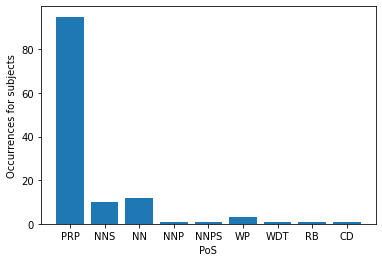

In [36]:
import matplotlib.pyplot as plt

plt.xlabel("PoS")
plt.ylabel("Occurrences for subjects")
plt.bar(pos_subj.keys(), pos_subj.values())
plt.show()

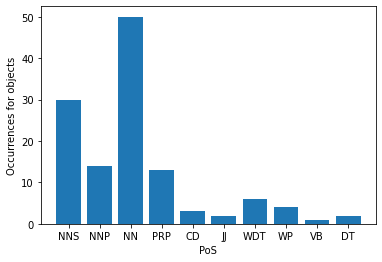

In [37]:
plt.xlabel("PoS")
plt.ylabel("Occurrences for objects")
plt.bar(pos_obj.keys(), pos_obj.values())
plt.show()